In [4]:
import pandas as pd
import numpy as np
import re
import datetime
import time
import geopandas as gpd
import geodatasets
import contextily as cx
import matplotlib.pyplot as plt

In [5]:
checkbook = pd.read_csv('checkbook_nyc_groupby_capital_project_fy.csv')
cpdb = pd.read_csv('../data/cpdb/cpdb_projects.csv')
print(checkbook.shape[0], cpdb.shape[0])

80932 12478


In [6]:
cpdb_gdf_poly = gpd.read_file('../data/cpdb/cpdb_dcpattributes_poly.shp/')
cpdb_gdf_pts = gpd.read_file('../data/cpdb/cpdb_dcpattributes_pts.shp/')

In [7]:
# filter dataframe to include only projects from this fiscal year
checkbook_2023 = checkbook[checkbook['Fiscal year']==2023]

In [8]:
# left join on Checkbook NYC 2023 with CPDB (no geoms)
join_cpdb_checkbook_2023 = checkbook_2023.merge(cpdb, how='left', left_on='FMS ID', right_on='maprojid', indicator=True)
join_cpdb_checkbook_2023.drop('Unnamed: 0', axis=1, inplace=True)

In [9]:
# percent checkbook nyc projects that can be matched to CPDB rows (no geometries)
num_matches_no_geoms = join_cpdb_checkbook_2023[join_cpdb_checkbook_2023['_merge']=='both']
print(num_matches_no_geoms.shape[0]/checkbook_2023.shape[0])

0.5922073890096243


## Matching Checkbook NYC 2023 Projects on CPDB geometries

In [10]:
def filter_by_year(df, year):
    # pass year as int
    return df[df['Fiscal year']==year]

def join_checkbook_and_cpdb_geoms(df, pts, poly):
    df_pts = df.merge(pts, how='left', left_on='FMS ID', right_on='maprojid', indicator=True)
    df_pts.drop('Unnamed: 0', axis=1, inplace=True)

    df_poly = df.merge(poly, how='left', left_on='FMS ID', right_on='maprojid', indicator=True)
    df_poly.drop('Unnamed: 0', axis=1, inplace=True)

    pts_matched = df_pts[df_pts['_merge']=='both']
    poly_matched = df_poly[df_poly['_merge']=='both']

    temp_df = pd.concat([pts_matched, poly_matched], ignore_index=True)
    temp_df.drop('_merge', axis=1, inplace=True)
    gdf = gpd.GeoDataFrame(temp_df, geometry='geometry')

    return gdf

temp_gdf = join_checkbook_and_cpdb_geoms(checkbook_2023, cpdb_gdf_pts, cpdb_gdf_poly)
temp_gdf.head(5)

,Agency,Associated Prime Vendor,Budget Code,Capital Project,Check Amount,Contract ID,Contract Purpose,Department,Document ID,Emerging Business,...,magency,magencyacr,projectid,descriptio,typecatego,geomsource,dataname,datasource,datadate,geometry
0,Queens Borough Public Library,NaN,"FREQ (FAR ROCKAWAY LIBRARY (1637 CENTRAL AVE,)",039LQQ122FAO007,496523.88,CT103920211413231,Far Rockaway- Office Resources Inc. - Furniture,400-039-D22,20230165556-1-DSB-AD,No,...,039,QBPL,LQQ122FAO,FAR ROCKAWAY OUTFITTING,Fixed Asset,AD Sprint,NaN,NaN,NaN,MULTIPOINT (-73.75209 40.60477)
1,Police Department,NaN,"HVPK (NYPD: 20TH, 24TH, 25TH PCTS: INSTALL NEW)",056PO79BMAHO001,137650.00,CT105620171417611,Replacement & Upgrade of Air Condition -25PSH,400-056-207,20230314405-1-DSB-EFT,No,...,056,NYPD,PO79BMAHO,"HVAC REPLACEMENT FOR 20TH, 24TH AND 25TH PCTS",Fixed Asset,agency,dcp_cpdb_agencyverified,agency,NaN,MULTIPOINT (-73.97502 40.78405)
2,Police Department,NaN,FIRN (CONEY ISLAND FIRING RANGE: DESIGN ASSOCA),056PO79BMAHS001,115513.27,CT105620181421797,REQUIREMENTS CONTRACT FOR ARCHITECTURAL & ENGI...,400-056-207,20230213921-1-DSB-EFT,No,...,056,NYPD,PO79BMAHS,FIRING RANGE RECONSTRUCTION AT CONEY ISLAND,Fixed Asset,agency,dcp_cpdb_agencyverified,agency,NaN,MULTIPOINT (-73.97659 40.58639)
3,Police Department,NaN,"BOL2 (NYPD: 26TH PCT (520 W 126ST, MN), 42ND P)",056PO79BMAHY002,19500.00,CT105620161422969,"Prof Engr. & Design for Boiler Sys. 26,42, & 4...",400-056-207,20230427415-1-DSB-EFT,No,...,056,NYPD,PO79BMAHY,"BOILERS AT 26TH, 42ND & 46TH PRECINCTS",Fixed Asset,agency,dcp_cpdb_agencyverified,agency,NaN,MULTIPOINT (-73.95668 40.81484)
4,Police Department,NaN,UPS1 (NYPD: 1 POLICE PLAZA ELEC SYSTEM UPGRAD),056PO79BMUPS001,9430766.66,CT105620218801481,Emergency Declaration for Replacement of Emerg...,400-056-207,20230106766-1-DSB-EFT,No,...,056,NYPD,PO79BMUPS,ONE POLICE PLAZA UPS,Fixed Asset,DCP_geojson,NaN,NaN,NaN,MULTIPOINT (-74.00174 40.71221)


In [11]:
def describe_cpdb_join_by_fy(df, gdf, year):
    n = df.shape[0]
    m = gdf.shape[0]

    print("Number of {} Checkbook NYC projects mapped to geometries: {}".format(year, m))
    print("Percent of {} Checkbook NYC projects mapped to geometries: {}".format(year, (m/n)*100))
    print("Sum of money from {} Checkbook NYC projects mapped to geometries: {}".format(year, round(sum(gdf['Check Amount']),2)))
    print("Percent of money from {} Checkbook NYC projects mapped to geometries: {}".format(year, (sum(gdf['Check Amount'])/sum(df['Check Amount']))*100))

describe_cpdb_join_by_fy(checkbook_2023, temp_gdf, '2023')

Number of 2023 Checkbook NYC projects mapped to geometries: 2010
Percent of 2023 Checkbook NYC projects mapped to geometries: 31.20149022042844
Sum of money from 2023 Checkbook NYC projects mapped to geometries: 1637699838.98
Percent of money from 2023 Checkbook NYC projects mapped to geometries: 14.577647650439168


In [14]:
# expressed as a proportion of all the projects from Checkbook NYC that matched to CPDB
describe_cpdb_join_by_fy(num_matches_no_geoms,temp_gdf, '2023')

Number of 2023 Checkbook NYC projects mapped to geometries: 2010
Percent of 2023 Checkbook NYC projects mapped to geometries: 52.6867627785059
Sum of money from 2023 Checkbook NYC projects mapped to geometries: 1637699838.98
Percent of money from 2023 Checkbook NYC projects mapped to geometries: 28.60051599861023


<Axes: >

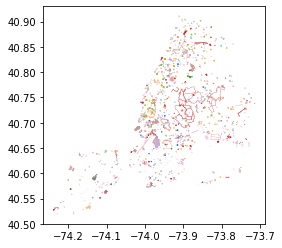

In [16]:
# visualize mapped geometries
nyc = gpd.read_file(geodatasets.get_path('nybb'))
temp_gdf.plot(cmap = 'tab20', column = 'Agency', markersize=0.1)
# fig, ax = plt.subplots(figsize=(0,0))
# nyc.plot(ax=ax, alpha=0.5)
# gdf.plot(ax=ax, cmap='tab20', column='Agency')
# cx.add_basemap(ax, crs=nyc.crs, source=cx.providers.Stamen.TonerLite)
# ax.set_axis_off()
# plt.show()


### Summary of findings